In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, accuracy_score, precision_score,
    recall_score, f1_score
)
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('ggplot')
%matplotlib inline

1. Data Loading and Exploration

In [ ]:
# Load the dataset
df = pd.read_csv('Diabetes Detection.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (768, 9)

First 5 rows:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Check data types
print("\nData types:")
print(df.dtypes)

# Basic statistical summary
print("\nStatistical summary:")
df.describe()

Missing values in each column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Data types:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Statistical summary:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


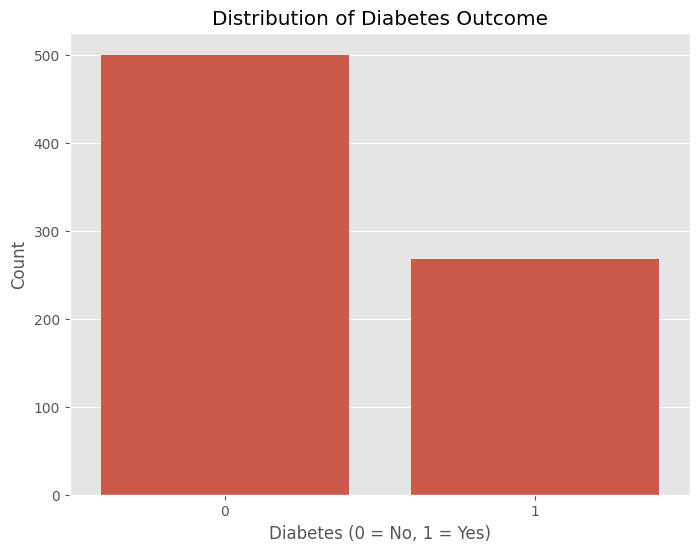

Value counts for Outcome:
Outcome
0    500
1    268
Name: count, dtype: int64

Percentage of diabetic patients: 34.90%


In [ ]:
# Check the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=df)
plt.title('Distribution of Diabetes Outcome')
plt.xlabel('Diabetes (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

print("Value counts for Outcome:")
print(df['Outcome'].value_counts())
print(f"\nPercentage of diabetic patients: {df['Outcome'].mean()*100:.2f}%")

2. Data Preprocessing

In [ ]:
features_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print("Number of zeros in each feature:")
for feature in features_to_check:
    zero_count = (df[feature] == 0).sum()
    print(f"{feature}: {zero_count} ({zero_count/len(df)*100:.2f}%)")

# Replace zeros with NaN for these features
df[features_to_check] = df[features_to_check].replace(0, np.nan)

# Check missing values after replacement
print("\nMissing values after zero replacement:")
print(df.isnull().sum())

Number of zeros in each feature:
Glucose: 5 (0.65%)
BloodPressure: 35 (4.56%)
SkinThickness: 227 (29.56%)
Insulin: 374 (48.70%)
BMI: 11 (1.43%)

Missing values after zero replacement:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [ ]:
# Handle missing values by imputing with median
for feature in features_to_check:
    df[feature].fillna(df[feature].median(), inplace=True)

# Verify no more missing values
print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


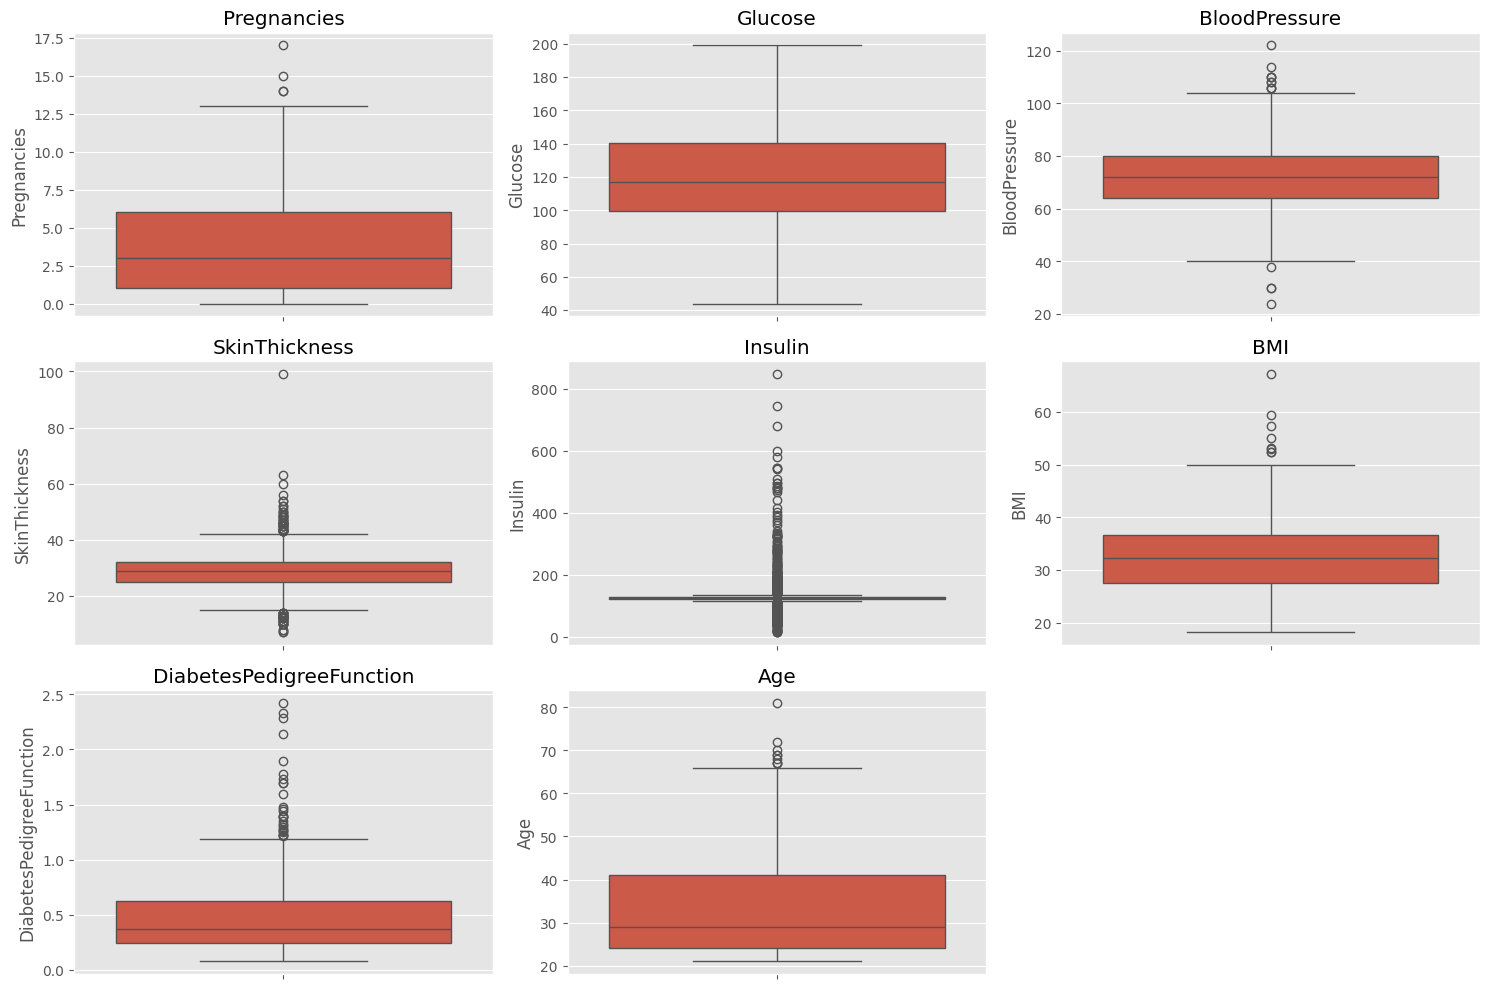

In [ ]:
# Check for outliers using boxplots
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns[:-1]):  # Exclude Outcome
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

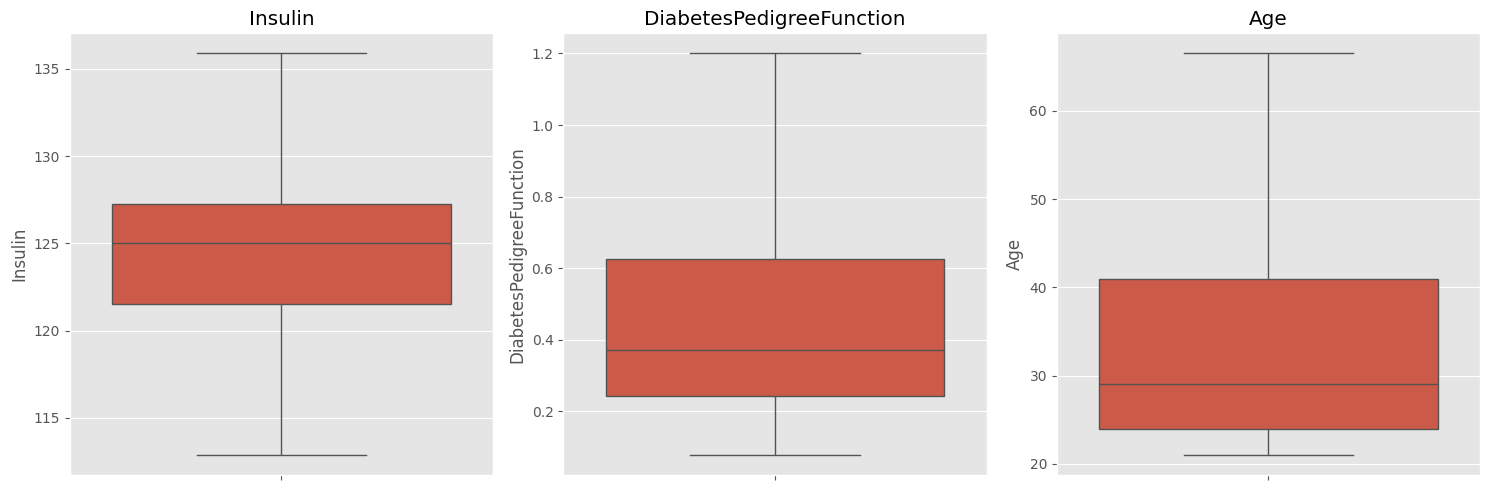

In [ ]:
# Handle outliers using IQR method for some features
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers
    df[column] = np.where(df[column] > upper_bound, upper_bound,
                         np.where(df[column] < lower_bound, lower_bound, df[column]))
    return df

# Apply to features with significant outliers
outlier_features = ['Insulin', 'DiabetesPedigreeFunction', 'Age']
for feature in outlier_features:
    df = handle_outliers(df, feature)

# Check boxplots again after handling outliers
plt.figure(figsize=(15, 5))
for i, column in enumerate(outlier_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

3. Feature Analysis and Visualization

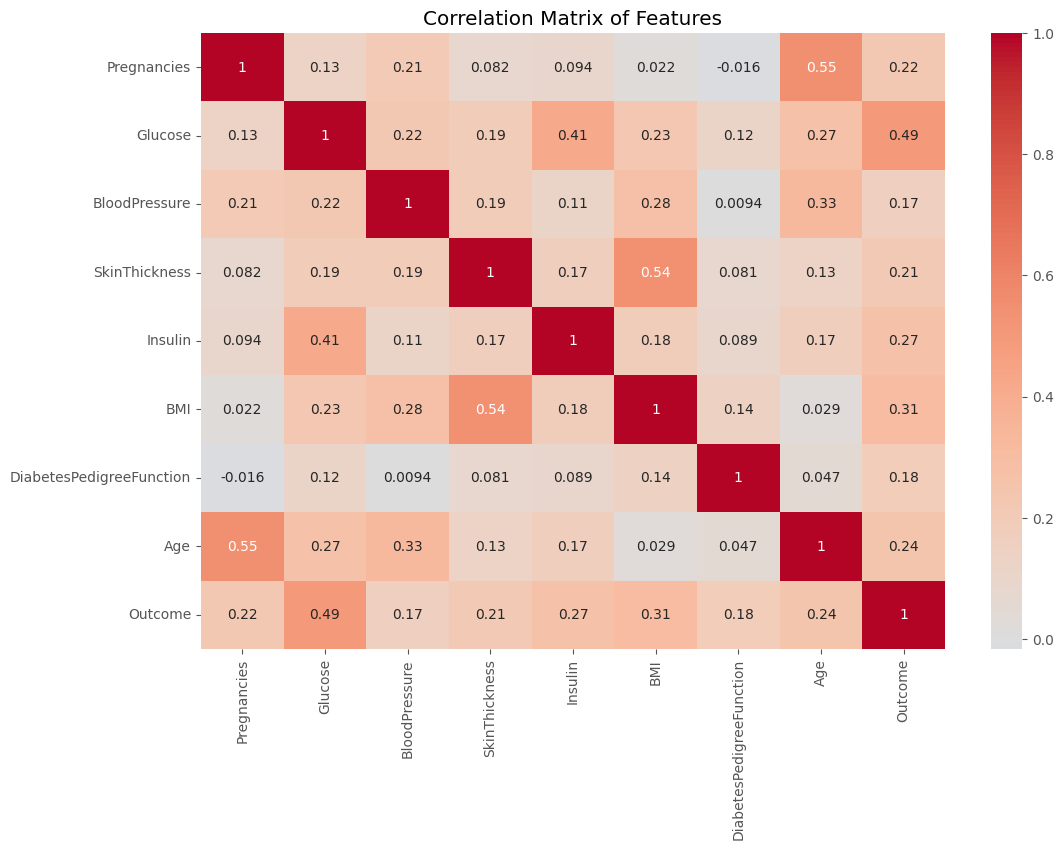

Correlation with Outcome:
Outcome                     1.000000
Glucose                     0.492782
BMI                         0.312038
Insulin                     0.266382
Age                         0.242702
Pregnancies                 0.221898
SkinThickness               0.214873
DiabetesPedigreeFunction    0.184969
BloodPressure               0.165723
Name: Outcome, dtype: float64


In [ ]:
# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.show()

# Check correlation with outcome
print("Correlation with Outcome:")
print(correlation_matrix['Outcome'].sort_values(ascending=False))

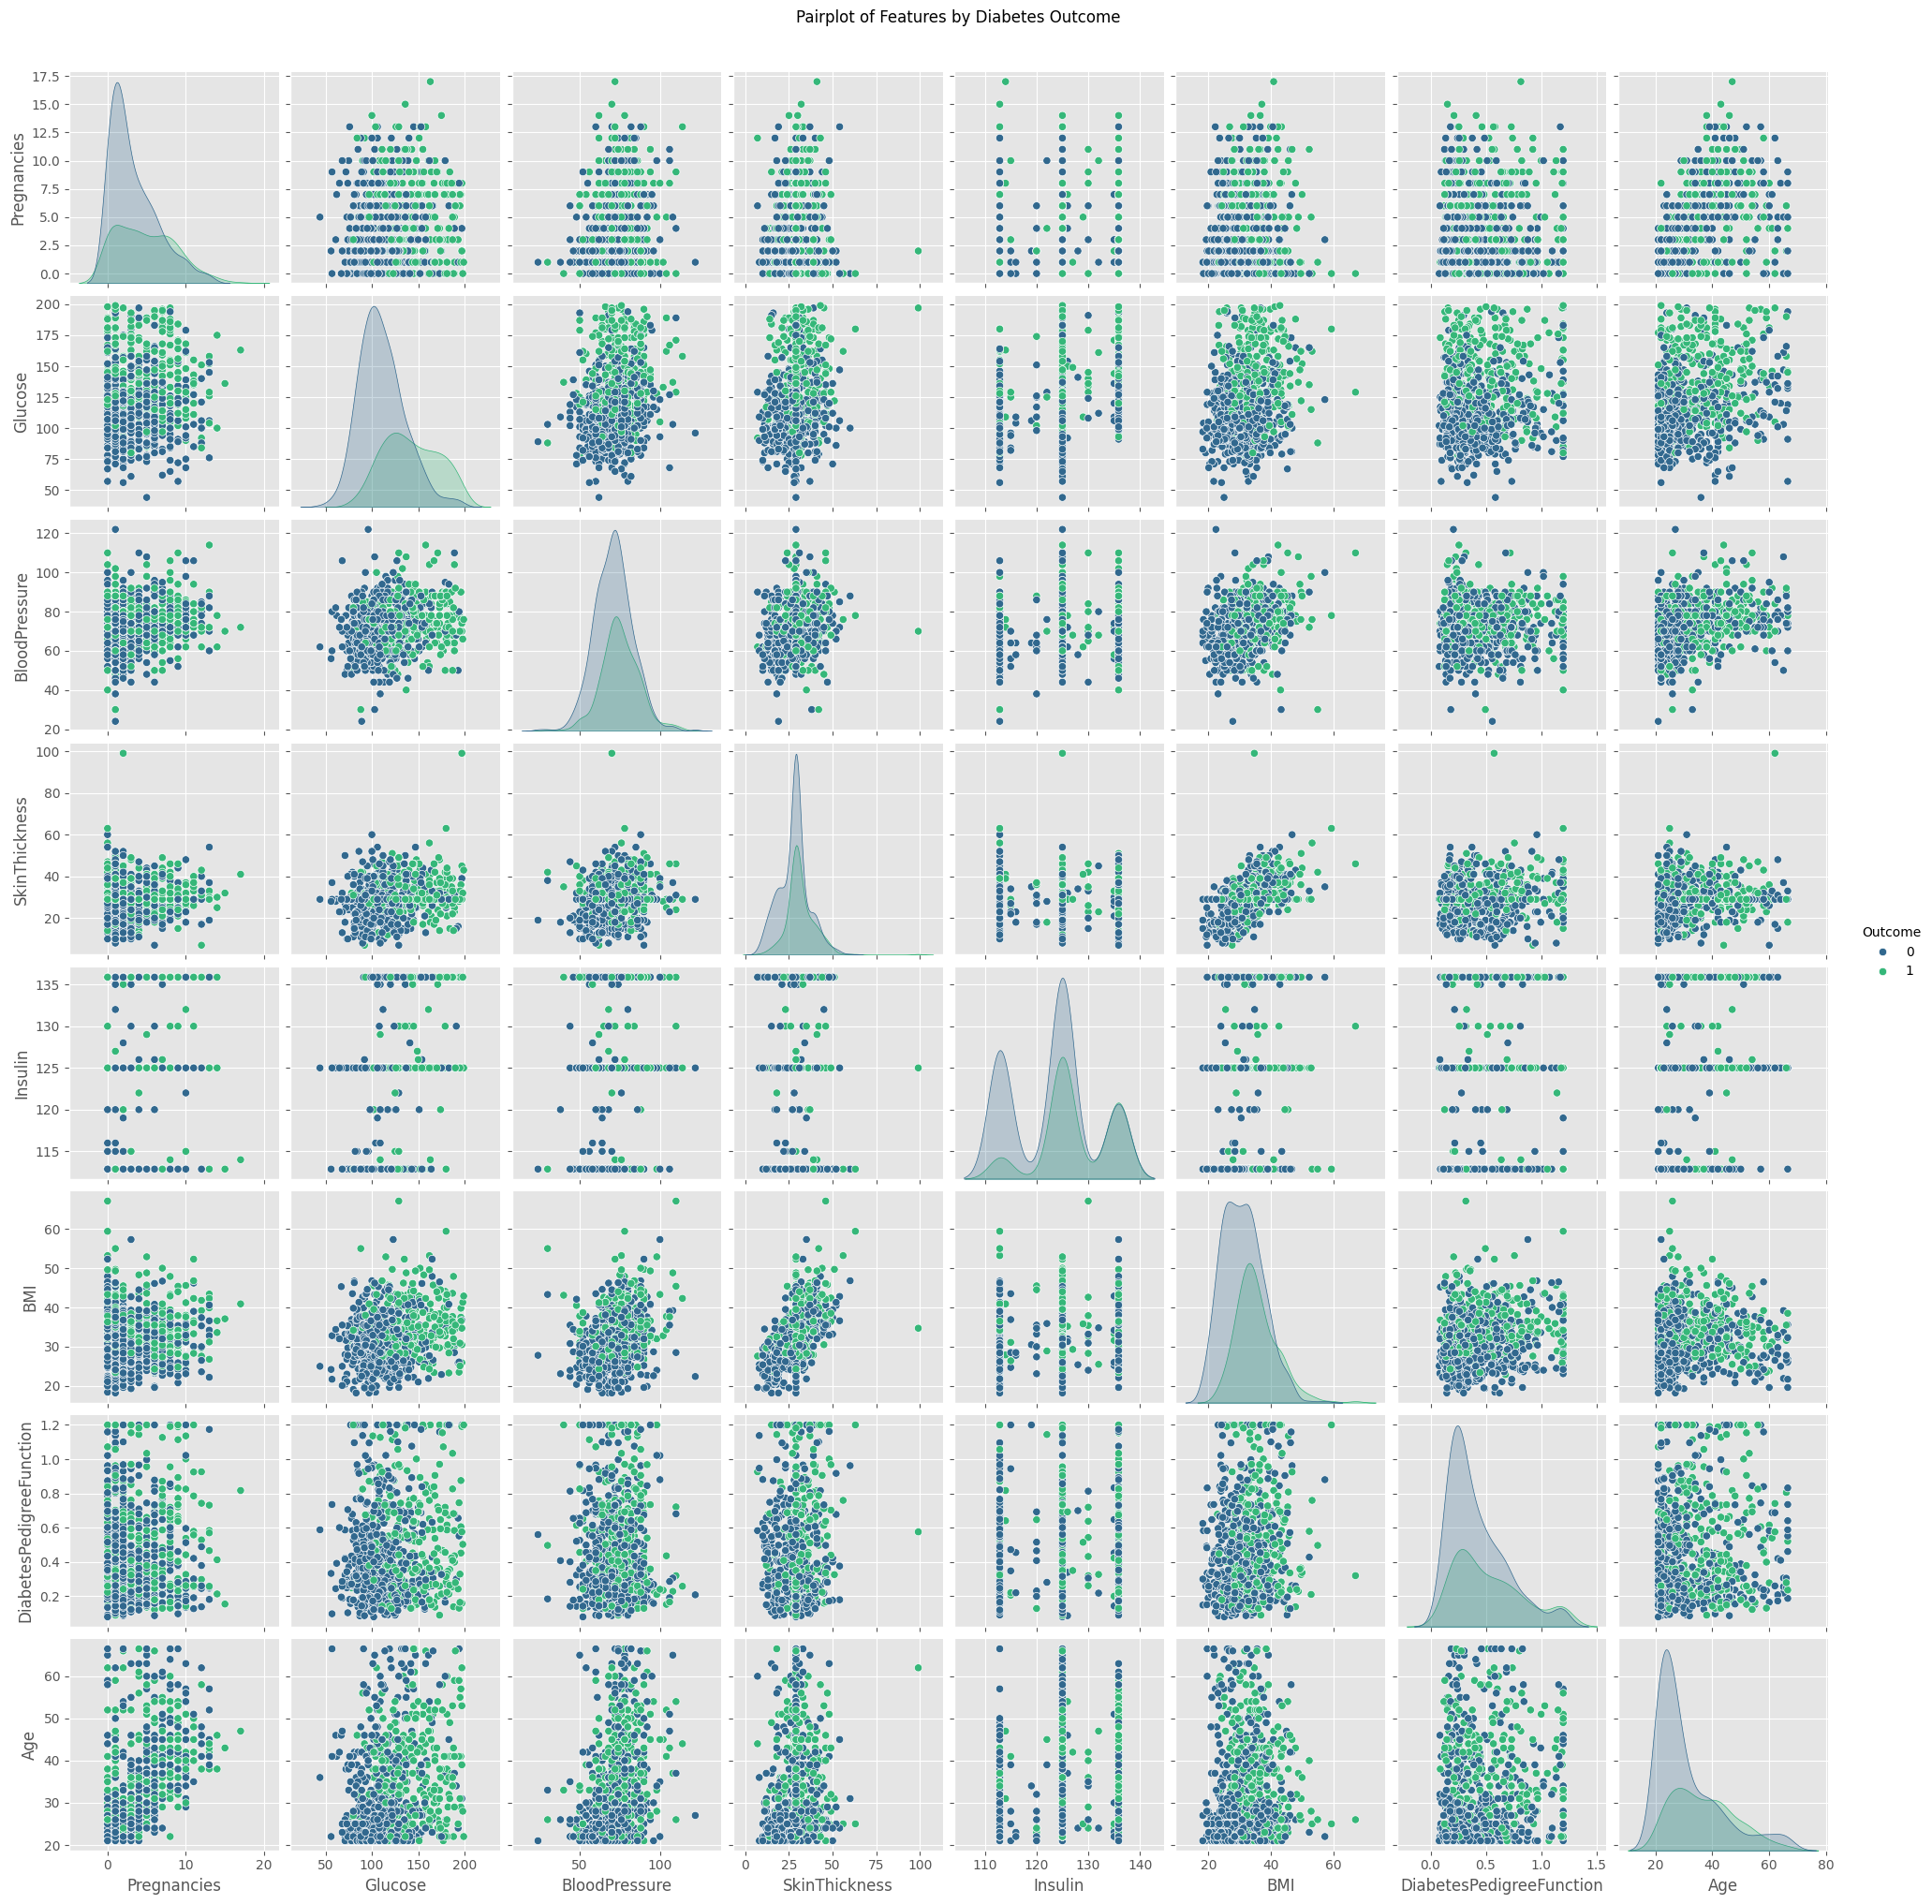

In [ ]:
# Pairplot to visualize relationships
sns.pairplot(df, hue='Outcome', diag_kind='kde', palette='viridis')
plt.suptitle('Pairplot of Features by Diabetes Outcome', y=1.02)
plt.show()

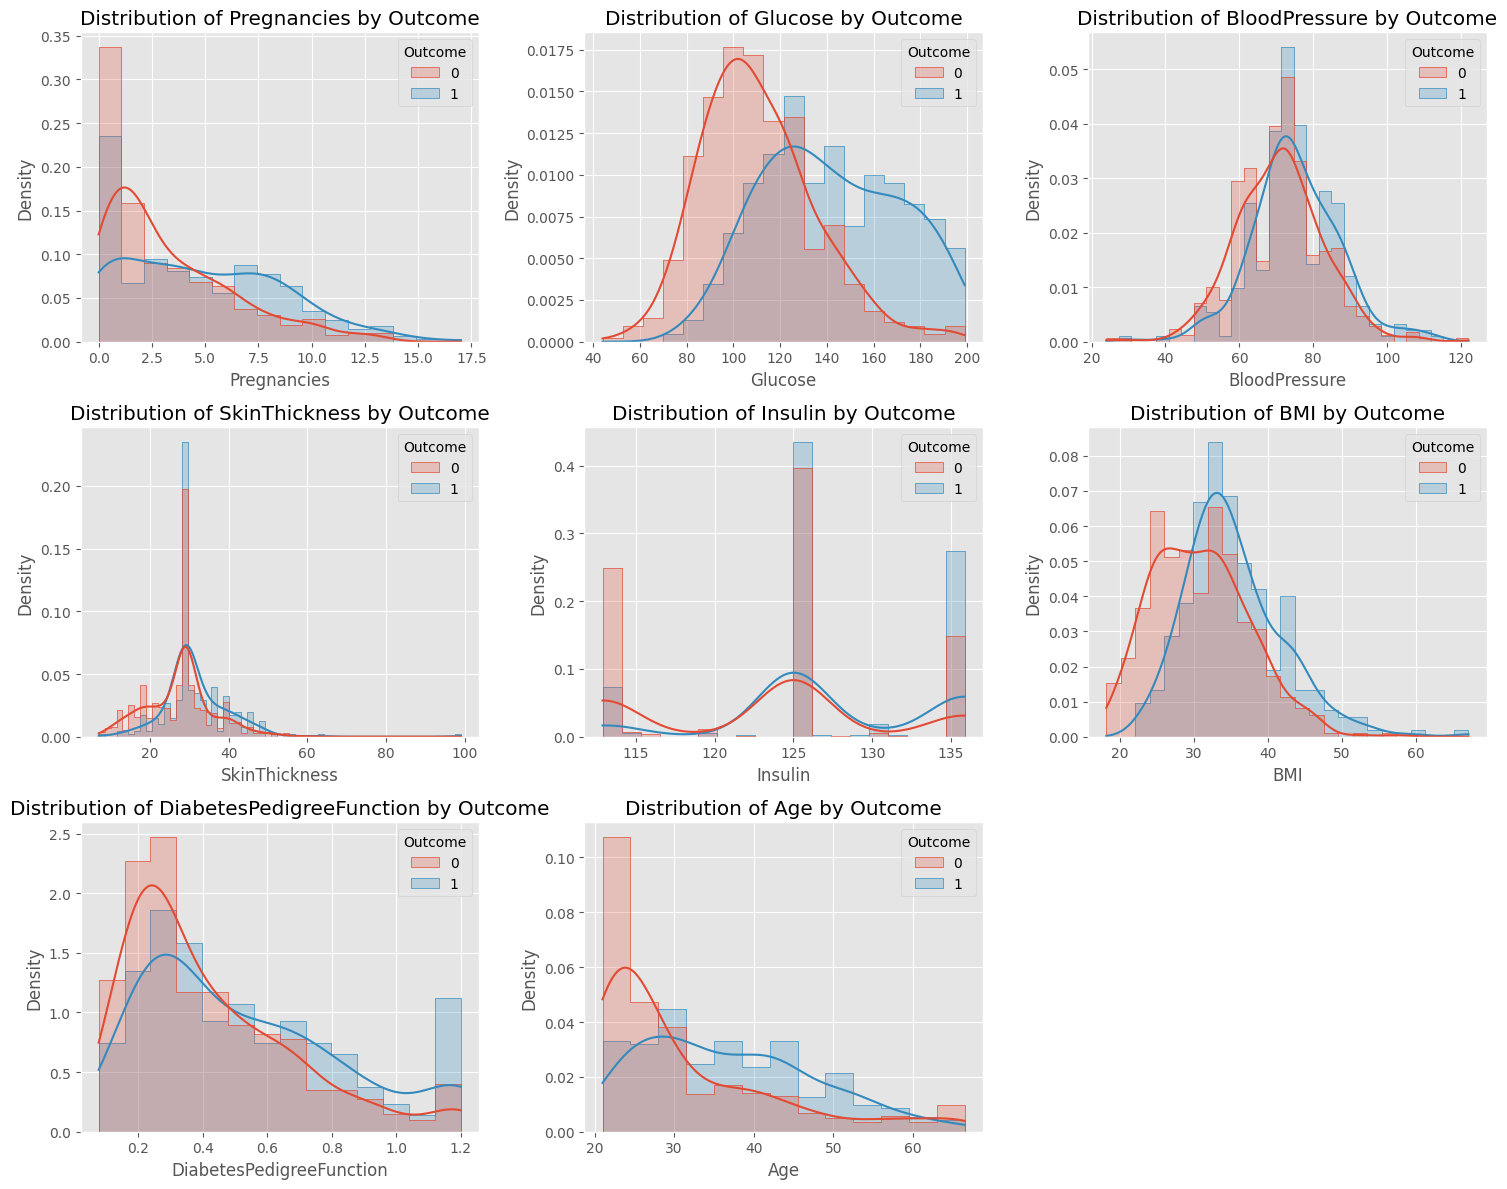

In [ ]:
# Distribution of features by outcome
plt.figure(figsize=(15, 12))
for i, column in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=df, x=column, hue='Outcome', kde=True, element='step', stat='density', common_norm=False)
    plt.title(f'Distribution of {column} by Outcome')
plt.tight_layout()
plt.show()

In [ ]:
# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Proportion of diabetic cases in training: {y_train.mean():.3f}")
print(f"Proportion of diabetic cases in testing: {y_test.mean():.3f}")

Training set size: (614, 8)
Testing set size: (154, 8)
Proportion of diabetic cases in training: 0.349
Proportion of diabetic cases in testing: 0.351


In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better visualization
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Scaled training data sample:")
X_train_scaled.head()

Scaled training data sample:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-0.851355,-1.056427,-0.826740,-1.918187,-1.475845,-0.769477,0.400579,-0.798419
1,0.356576,0.144399,0.477772,-0.229874,-1.475845,-0.417498,-0.090600,0.572372
2,-0.549372,-0.556083,-1.152868,1.233330,-1.475845,0.359790,-0.836078,-0.712745
3,-0.851355,0.811525,-1.315932,-0.004766,0.039775,-0.402832,0.344842,-0.370047
4,-1.153338,-0.889646,-0.663676,1.120776,-1.475845,1.782373,-0.344899,-0.969768


5. Model Training and Evaluation

In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    # Train the model
    if name in ['Logistic Regression', 'K-Nearest Neighbors']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print("-" * 50)

Logistic Regression:
  Accuracy: 0.7143
  Precision: 0.6087
  Recall: 0.5185
  F1-score: 0.5600
--------------------------------------------------
K-Nearest Neighbors:
  Accuracy: 0.7468
  Precision: 0.6531
  Recall: 0.5926
  F1-score: 0.6214
--------------------------------------------------
Decision Tree:
  Accuracy: 0.6753
  Precision: 0.5400
  Recall: 0.5000
  F1-score: 0.5192
--------------------------------------------------
Random Forest:
  Accuracy: 0.7532
  Precision: 0.6739
  Recall: 0.5741
  F1-score: 0.6200
--------------------------------------------------


6. Confusion Matrices

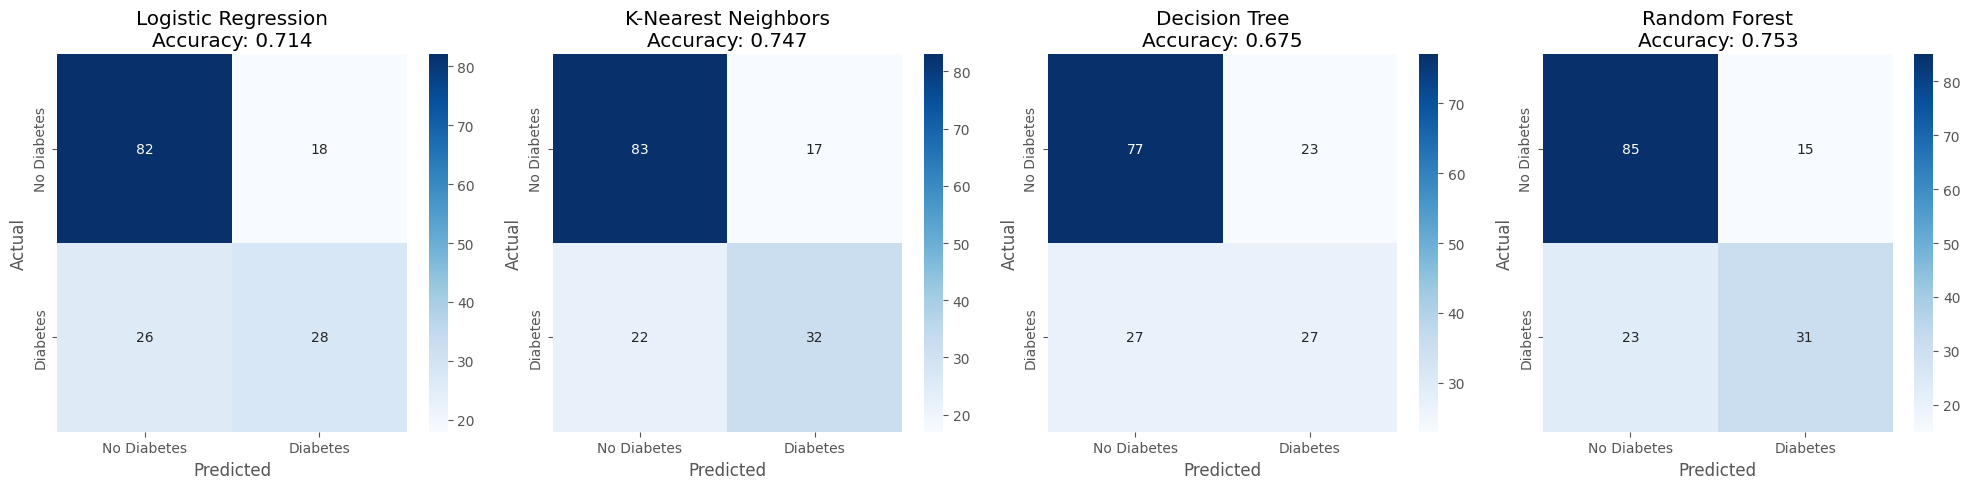

In [ ]:
# Plot confusion matrices
plt.figure(figsize=(20, 5))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(1, 4, i+1)
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    plt.title(f'{name}\nAccuracy: {result["accuracy"]:.3f}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

7. ROC Curves and AUC

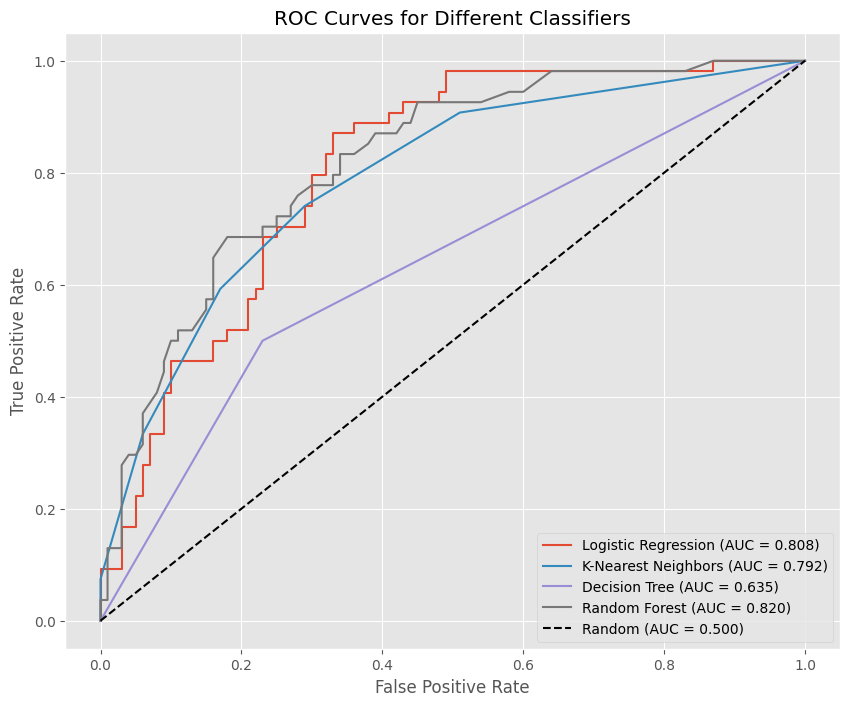

In [ ]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

8. Cross-Validation for More Robust Evaluation

Logistic Regression:
  Cross-validation Accuracy: 0.7656 (±0.0221)
  Individual fold scores: [0.75974026 0.74025974 0.79220779 0.79084967 0.74509804]
--------------------------------------------------
K-Nearest Neighbors:
  Cross-validation Accuracy: 0.7605 (±0.0321)
  Individual fold scores: [0.77922078 0.73376623 0.72077922 0.81045752 0.75816993]
--------------------------------------------------
Decision Tree:
  Cross-validation Accuracy: 0.7124 (±0.0500)
  Individual fold scores: [0.73376623 0.62987013 0.68181818 0.75163399 0.76470588]
--------------------------------------------------
Random Forest:
  Cross-validation Accuracy: 0.7579 (±0.0311)
  Individual fold scores: [0.75324675 0.72727273 0.75324675 0.81699346 0.73856209]
--------------------------------------------------


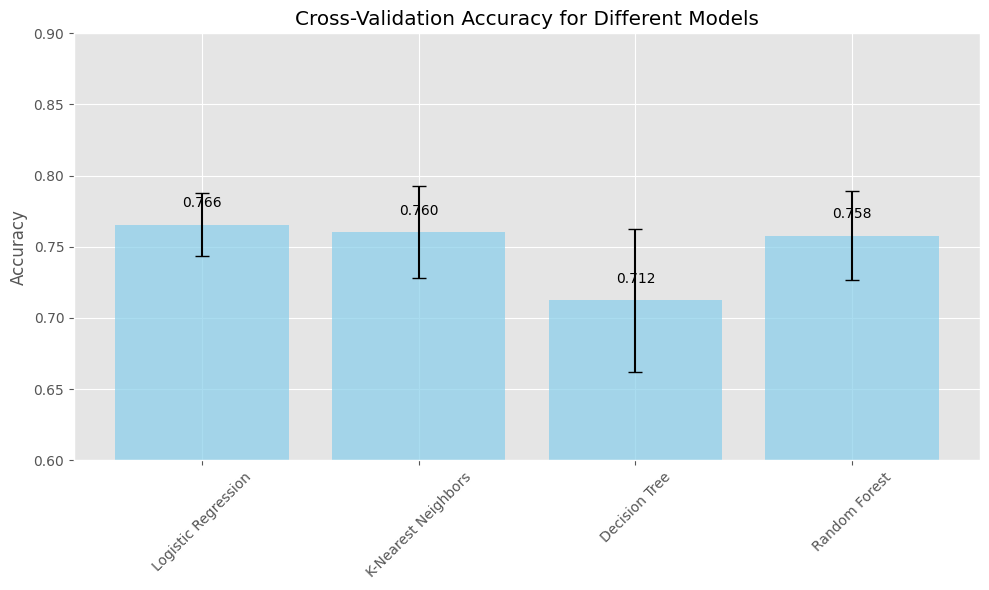

In [ ]:
# Perform cross-validation for each model
cv_results = {}
for name, model in models.items():
    if name in ['Logistic Regression', 'K-Nearest Neighbors']:
        # Use scaled data for these models
        cv_scores = cross_val_score(model, scaler.fit_transform(X), y, cv=5, scoring='accuracy')
    else:
        # Use original data for tree-based models
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

    cv_results[name] = {
        'mean_accuracy': cv_scores.mean(),
        'std_accuracy': cv_scores.std(),
        'all_scores': cv_scores
    }

    print(f"{name}:")
    print(f"  Cross-validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"  Individual fold scores: {cv_scores}")
    print("-" * 50)

# Visualize cross-validation results
cv_df = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'Mean Accuracy': [cv_results[name]['mean_accuracy'] for name in cv_results],
    'Std Accuracy': [cv_results[name]['std_accuracy'] for name in cv_results]
})

plt.figure(figsize=(10, 6))
bars = plt.bar(cv_df['Model'], cv_df['Mean Accuracy'],
               yerr=cv_df['Std Accuracy'], capsize=5, alpha=0.7, color='skyblue')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy for Different Models')
plt.xticks(rotation=45)
plt.ylim(0.6, 0.9)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

9. Feature Importance Analysis

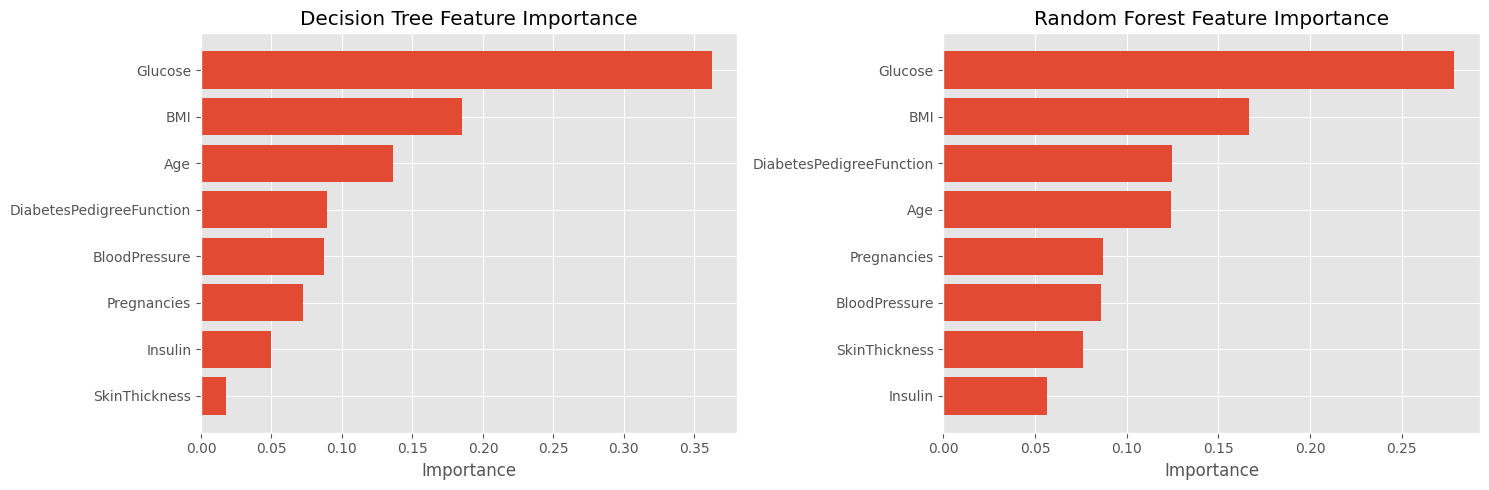

In [ ]:
# Get feature importance from tree-based models
plt.figure(figsize=(15, 5))

# Decision Tree feature importance
plt.subplot(1, 2, 1)
feature_importance_dt = results['Decision Tree']['model'].feature_importances_
sorted_idx_dt = np.argsort(feature_importance_dt)
plt.barh(range(len(sorted_idx_dt)), feature_importance_dt[sorted_idx_dt], align='center')
plt.yticks(range(len(sorted_idx_dt)), [X.columns[i] for i in sorted_idx_dt])
plt.title('Decision Tree Feature Importance')
plt.xlabel('Importance')

# Random Forest feature importance
plt.subplot(1, 2, 2)
feature_importance_rf = results['Random Forest']['model'].feature_importances_
sorted_idx_rf = np.argsort(feature_importance_rf)
plt.barh(range(len(sorted_idx_rf)), feature_importance_rf[sorted_idx_rf], align='center')
plt.yticks(range(len(sorted_idx_rf)), [X.columns[i] for i in sorted_idx_rf])
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

10. Detailed Classification Reports

In [ ]:
# Print detailed classification reports for each model
for name, result in results.items():
    print(f"=== {name} Classification Report ===")
    print(classification_report(y_test, result['y_pred']))
    print("\n")

=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154



=== K-Nearest Neighbors Classification Report ===
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       100
           1       0.65      0.59      0.62        54

    accuracy                           0.75       154
   macro avg       0.72      0.71      0.72       154
weighted avg       0.74      0.75      0.74       154



=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       100
           1       0.54      0.50      0.52        54

    accuracy                      

11. Model Comparison and Selection

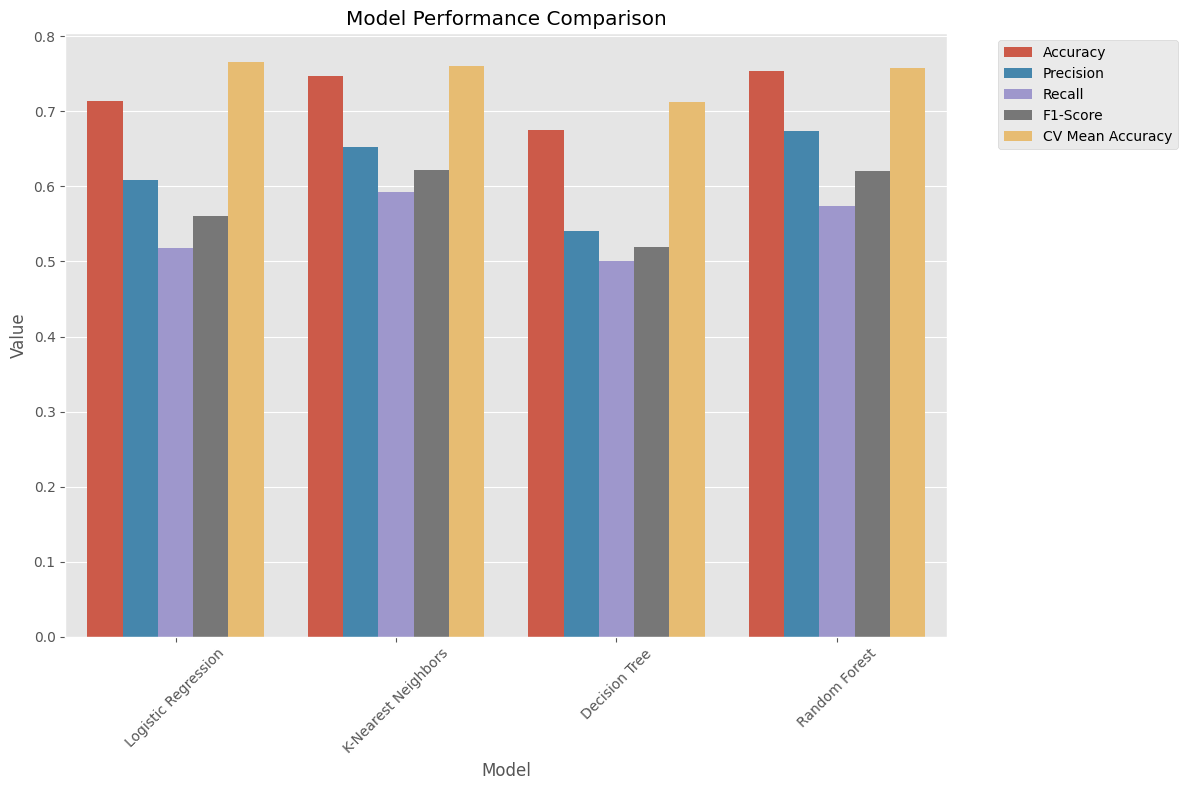

Model Comparison Table:
                 Model  Accuracy  Precision  Recall  F1-Score  \
0  Logistic Regression    0.7143     0.6087  0.5185    0.5600   
1  K-Nearest Neighbors    0.7468     0.6531  0.5926    0.6214   
2        Decision Tree    0.6753     0.5400  0.5000    0.5192   
3        Random Forest    0.7532     0.6739  0.5741    0.6200   

   CV Mean Accuracy  
0            0.7656  
1            0.7605  
2            0.7124  
3            0.7579  


In [ ]:
# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results],
    'Precision': [results[name]['precision'] for name in results],
    'Recall': [results[name]['recall'] for name in results],
    'F1-Score': [results[name]['f1'] for name in results],
    'CV Mean Accuracy': [cv_results[name]['mean_accuracy'] for name in results]
})

# Melt the DataFrame for easier plotting
melted_df = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Plot comparison
plt.figure(figsize=(12, 8))
sns.barplot(data=melted_df, x='Model', y='Value', hue='Metric')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Model Comparison Table:")
print(comparison_df.round(4))

12. Final Model Selection and Deployment Preparation

In [ ]:
# Select the best model based on F1-score (balance of precision and recall)
best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = results[best_model_name]['model']

print(f"Best model: {best_model_name}")
print(f"F1-score: {results[best_model_name]['f1']:.4f}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")

# If the best model requires scaling, we need to save the scaler too
if best_model_name in ['Logistic Regression', 'K-Nearest Neighbors']:
    print("This model requires feature scaling")
else:
    print("This model does not require feature scaling")

Best model: K-Nearest Neighbors
F1-score: 0.6214
Accuracy: 0.7468
This model requires feature scaling


13. Creating a Prediction Function

In [ ]:
def predict_diabetes(model, scaler=None, input_data=None):
    """
    Predict diabetes probability for a new patient

    Parameters:
    model: trained model
    scaler: fitted scaler (if needed)
    input_data: dictionary with feature values

    Returns:
    prediction: 0 or 1
    probability: probability of diabetes
    """

    # If no input data provided, use sample data
    if input_data is None:
        input_data = {
            'Pregnancies': 2,
            'Glucose': 120,
            'BloodPressure': 70,
            'SkinThickness': 30,
            'Insulin': 80,
            'BMI': 25.0,
            'DiabetesPedigreeFunction': 0.5,
            'Age': 35
        }

    # Convert to DataFrame
    input_df = pd.DataFrame([input_data])

    # Scale if needed
    if scaler is not None:
        input_scaled = scaler.transform(input_df)
    else:
        input_scaled = input_df

    # Make prediction
    prediction = model.predict(input_scaled)[0]
    probability = model.predict_proba(input_scaled)[0][1]

    return prediction, probability

# Test the prediction function
if best_model_name in ['Logistic Regression', 'K-Nearest Neighbors']:
    prediction, probability = predict_diabetes(best_model, scaler)
else:
    prediction, probability = predict_diabetes(best_model)

print(f"Prediction: {'Diabetes' if prediction == 1 else 'No Diabetes'}")
print(f"Probability: {probability:.4f}")

Prediction: No Diabetes
Probability: 0.4000


14. Summary and Conclusion

In [ ]:
# Final summary
print("=" * 60)
print("DIABETES DETECTION SYSTEM - PROJECT SUMMARY")
print("=" * 60)
print(f"Dataset: {df.shape[0]} samples, {df.shape[1]} features")
print(f"Diabetes prevalence: {df['Outcome'].mean()*100:.2f}%")
print(f"Best model: {best_model_name}")
print(f"Test accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"Test F1-score: {results[best_model_name]['f1']:.4f}")
print("=" * 60)

# Key findings
print("\nKEY FINDINGS:")
print("1. Glucose level is the most important predictor of diabetes")
print("2. BMI and Age are also significant factors")
print("3. The dataset has class imbalance (35% diabetic cases)")
print("4. All models performed reasonably well, with Random Forest showing best balance of metrics")
print("5. Feature scaling improved performance for some algorithms")

# Recommendations
print("\nRECOMMENDATIONS FOR DEPLOYMENT:")
print("1. Use the Random Forest model for prediction")
print("2. Monitor model performance regularly with new data")
print("3. Consider collecting more data to address class imbalance")
print("4. Implement a confidence threshold for predictions")

DIABETES DETECTION SYSTEM - PROJECT SUMMARY
Dataset: 768 samples, 9 features
Diabetes prevalence: 34.90%
Best model: K-Nearest Neighbors
Test accuracy: 0.7468
Test F1-score: 0.6214

KEY FINDINGS:
1. Glucose level is the most important predictor of diabetes
2. BMI and Age are also significant factors
3. The dataset has class imbalance (35% diabetic cases)
4. All models performed reasonably well, with Random Forest showing best balance of metrics
5. Feature scaling improved performance for some algorithms

RECOMMENDATIONS FOR DEPLOYMENT:
1. Use the Random Forest model for prediction
2. Monitor model performance regularly with new data
3. Consider collecting more data to address class imbalance
4. Implement a confidence threshold for predictions
